# Overview

Fetch weather data from the [National Data Buoy Center](https://www.ndbc.noaa.gov/) and clean it.

# Imports and data loading

In [15]:
# Filesystem
from google.colab import drive

# Data manipulation
import datetime
import pandas as pd
import numpy as np

# Downloading data
import requests
import gzip
from io import StringIO

# Analysis
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_palette('Set2')
plt.style.use('fivethirtyeight')
sns.set(rc={'figure.figsize':(10,5)})

# Model fitting
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [16]:
# Load from github

url = 'https://raw.githubusercontent.com/natelac/Great-Lakes-Fishing-Data-and-Analysis/main/data/'
fish = pd.read_csv(url + 'fishing_unmerged.csv');
fishbd = pd.read_csv(url + 'fishing_by_date_unmerged.csv');

In [17]:
# Load from colab

# drive.mount('/content/drive', force_remount=True);

# path_to_folder = 'drive/My Drive/Colab Notebooks/Fishing/data/'
# fish = pd.read_csv(path_to_folder + 'fishing_unmerged.csv');
# fishbd = pd.read_csv(path_to_folder + 'fishing_by_date_unmerged.csv');

Mounted at /content/drive


# Fetch and clean data from NOAA

Luckily the National Oceanic and Atmospheric Administration (NOAA) collects not only weather for oceans, but for inland lakes if they're big enough!

The units for the data are this:

`yr  mo dy hr mn degT m/s m/s m sec sec deg hPa degC degC degC nmi ft`

For the columns I keep:

`yr  mo dy hr degT m/s m/s hPa degC degC`

In [18]:
# Fetch historical weather data

# Download data from NOAA website
years = range(2010, 2021)
dfs = []
for year in years:
    r = requests.get(
        f"https://www.ndbc.noaa.gov/data/historical/stdmet/mcgm4h{year}.txt.gz"
    )
    txt = gzip.decompress(r.content)
    txt_str = txt.decode('utf-8')
    txt_io = StringIO(txt_str)
    df = pd.read_csv(txt_io, delim_whitespace=True, skiprows=[1])
    dfs.append(df)

# Combine into one dataframe
df_full = pd.DataFrame()
for df in dfs:
    df_full = pd.concat((df_full, df))
df_full = df_full.reset_index(drop=True)

In [19]:
# Clean data

# Drop nan columns
df_full.drop(columns=['TIDE', 'VIS', 'WTMP', 'MWD', 'APD', 'DPD', 'WVHT'], 
             inplace=True)

# Recode nans to np.nan
df_full.loc[df_full['DEWP'] == 999, 'DEWP'] = np.nan
df_full.loc[df_full['ATMP'] == 999, 'ATMP'] = np.nan
df_full.loc[df_full['PRES'] == 9999, 'PRES'] = np.nan
df_full.loc[df_full['GST'] == 99, 'GST'] = np.nan
df_full.loc[df_full['WSPD'] == 99, 'WSPD'] = np.nan
df_full.loc[df_full['WDIR'] == 999, 'WDIR'] = np.nan

# Rename columns
df_full.columns = ['year', 'month', 'day', 'hour' ,'minute', 'wind_dir', 
                   'wind_speed', 'gust_speed', 'pressure', 'air_temp',
                   'dew_point']

In [20]:
# Re-index by hour and create new features

# Average within hours since measurements by minute don't seem accurate
dfbh = df_full.groupby(['year', 'month', 'day', 'hour']).mean().reset_index() 

# Convert numerical dates to datetime objects
dfbh['date'] = pd.to_datetime(dfbh[['year','month','day']])
dfbh['time'] = pd.to_datetime(dfbh[['year','month','day','hour']])

# Calculate change in measurements between hours
diffs = dfbh.diff()[['wind_dir', 'wind_speed', 'gust_speed', 
                     'pressure', 'air_temp', 'dew_point']]
diffs.columns = ['wind_dir_diff', 'wind_speed_diff', 'gust_speed_diff',
                 'pressure_diff', 'air_temp_diff', 'dew_point_diff']
dfbh = dfbh.join(diffs)
dfbh.drop(columns='minute', inplace=True)

# Re-organize columns
col_list = ['date', 'time', 'year', 'month', 'day', 'hour', 'wind_dir', 
            'wind_speed', 'gust_speed', 'pressure', 'air_temp', 'dew_point', 
            'wind_dir_diff', 'wind_speed_diff', 'gust_speed_diff', 
            'pressure_diff', 'air_temp_diff', 'dew_point_diff']
dfbh = dfbh.reindex(columns=col_list)

# Check out data

This data is measured from a physical buoy in the region where the fishing data was collected. For this reason, the data is very erratic on the minute timescale. When averaged over each hour the data is much more smooth, and it is much easier to identify trends.

It is also important to note, there are a lot of nans for `dew_point`. It seems like the sensor was not installed until later in the life of the buoy.

In [21]:
# View data
dfbh

,date,time,year,month,day,hour,wind_dir,wind_speed,gust_speed,pressure,air_temp,dew_point,wind_dir_diff,wind_speed_diff,gust_speed_diff,pressure_diff,air_temp_diff,dew_point_diff
0,2010-01-01,2010-01-01 00:00:00,2010,1,1,0,317.000000,3.550000,6.940000,1017.780000,-8.950000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-01,2010-01-01 01:00:00,2010,1,1,1,323.300000,4.000000,7.430000,1018.210000,-8.450000,NaN,6.300000,0.450000,0.490000,0.430000,0.500000,NaN
2,2010-01-01,2010-01-01 02:00:00,2010,1,1,2,335.714286,4.228571,8.842857,1018.685714,-8.071429,NaN,12.414286,0.228571,1.412857,0.475714,0.378571,NaN
3,2010-01-01,2010-01-01 03:00:00,2010,1,1,3,345.600000,5.070000,9.660000,1018.970000,-7.700000,NaN,9.885714,0.841429,0.817143,0.284286,0.371429,NaN
4,2010-01-01,2010-01-01 04:00:00,2010,1,1,4,349.200000,5.980000,10.620000,1019.470000,-7.490000,NaN,3.600000,0.910000,0.960000,0.500000,0.210000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95816,2020-12-31,2020-12-31 19:00:00,2020,12,31,19,198.500000,3.450000,5.320000,1021.220000,-2.030000,-9.3500,-8.800000,0.740000,0.900000,0.330000,0.580000,-0.0200
95817,2020-12-31,2020-12-31 20:00:00,2020,12,31,20,187.000000,3.262500,4.962500,1020.912500,-1.650000,-9.3625,-11.500000,-0.187500,-0.357500,-0.307500,0.380000,-0.0125
95818,2020-12-31,2020-12-31 21:00:00,2020,12,31,21,186.800000,2.770000,4.610000,1021.300000,-1.710000,-9.4600,-0.200000,-0.492500,-0.352500,0.387500,-0.060000,-0.0975
95819,2020-12-31,2020-12-31 22:00:00,2020,12,31,22,181.700000,3.420000,4.770000,1021.870000,-2.310000,-9.3400,-5.100000,0.650000,0.160000,0.570000,-0.600000,0.1200


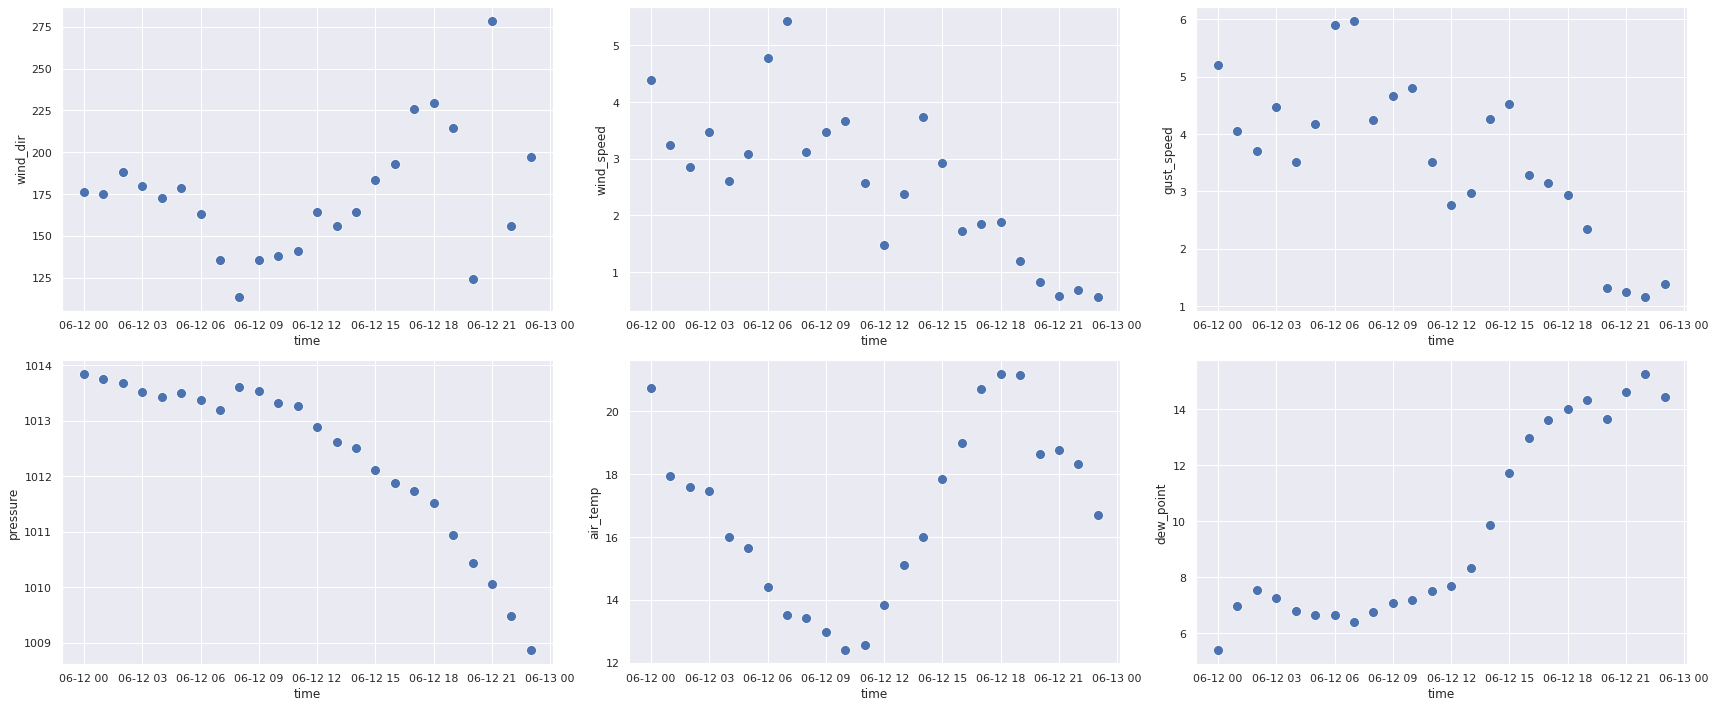

In [22]:
# Plot all the new data

fig, axs = plt.subplots(2, 3)
fig.set_size_inches(24, 10)

mask = (dfbh['date'] >= '2018-06-12') & \
       (dfbh['date'] < '2018-06-13')

cols = ['wind_dir', 'wind_speed', 'gust_speed', 
        'pressure', 'air_temp', 'dew_point']

for i, col in enumerate(cols):
    sns.scatterplot(x = dfbh.loc[mask, 'time'],
                    y = dfbh.loc[mask, col],
                    ax=axs.flat[i],
                    s=100)
    
fig.tight_layout()

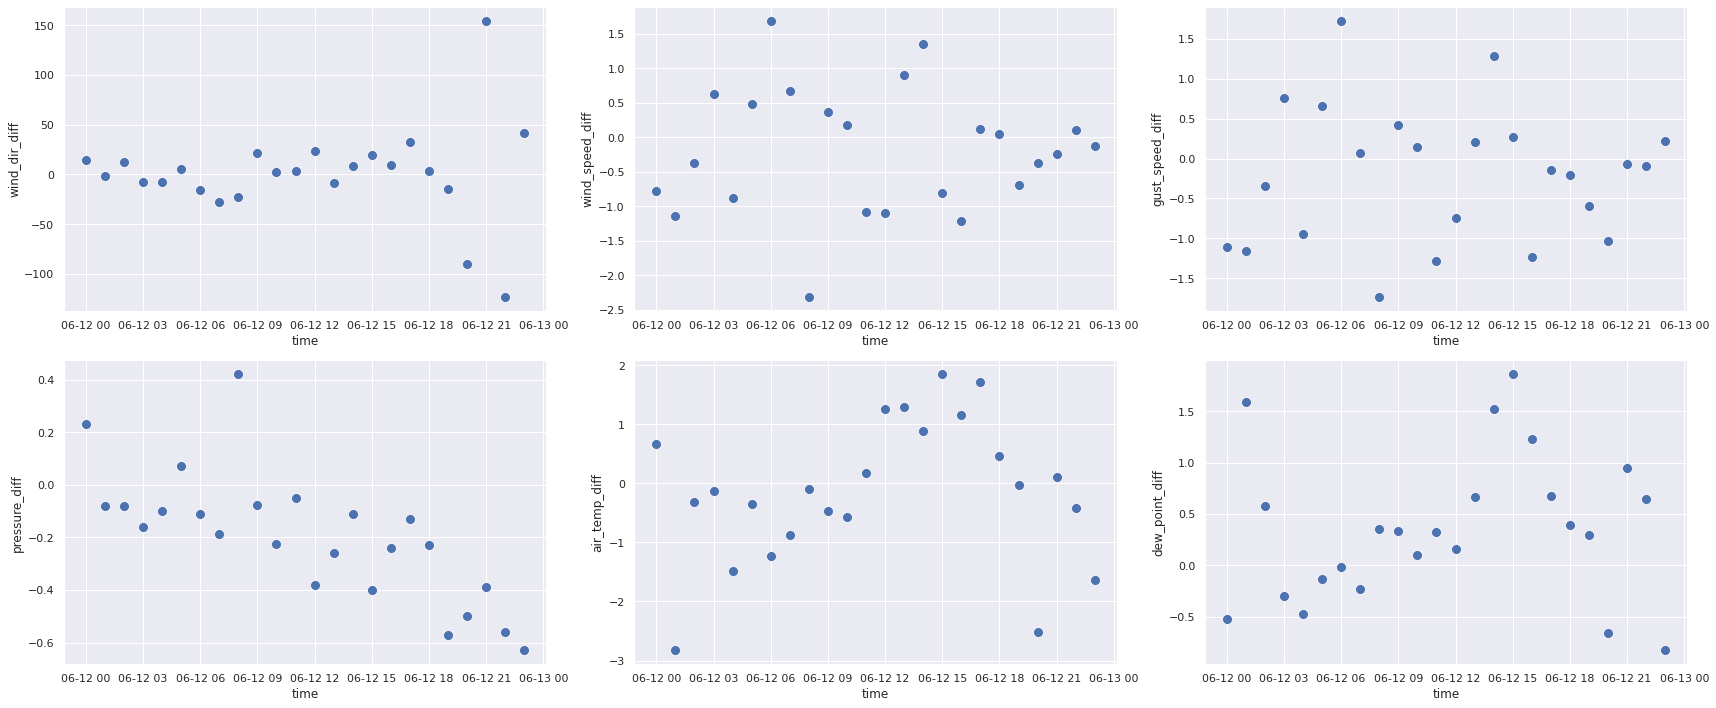

In [23]:
# Plot all the diffs

fig, axs = plt.subplots(2, 3)
fig.set_size_inches(24, 10)

mask = (dfbh['date'] >= '2018-06-12') & \
       (dfbh['date'] < '2018-06-13')

for i, col in enumerate(diffs.columns):
    sns.scatterplot(x = dfbh.loc[mask, 'time'],
                    y = dfbh.loc[mask, col],
                    ax=axs.flat[i],
                    s=100)
    
fig.tight_layout()

# Combine with fishing data and export

The 'time' column in the fishing data is a bit more granular than one hour which makes merging the data a little more tricky. Going back and change the data scale to minutes / half hours / quarter hours might not be as good as it sounds because of how erratic the data is at that resolution. The data appears pretty smooth and continuous at one hour resolution so we will keep it at one hour.

The diffs are how the weather changes within the previous hour. Ideally it should always be the pressure leading up to when a fish is caught, so fish caught in the middle of an hour or higher will be rounded up an hour.

There are some `nan` values where the buoy wasn't recording, but it is only 5 or 7 days so we can mostly ignore it. We can drop the rows if it is an issue without worrying about skewing our data.

In [24]:
# Combine old and new metrics

# Drop columns that we have measurements for
drop_columns = ['air_temp', 'wind_level', 'wind_dir']
fish_drp = fish.drop(columns=drop_columns)
fishbd_drp = fishbd.drop(columns=drop_columns)

# Columns collected from buoy
new_cols = ['wind_dir', 'wind_speed', 'gust_speed', 'pressure', 'air_temp', 
            'dew_point', 'wind_dir_diff', 'wind_speed_diff', 'gust_speed_diff', 
            'pressure_diff', 'air_temp_diff', 'dew_point_diff']

def combine_metrics(row):

    # Get date and time
    date, time = row.time.split(' ')
    hour, minute, _ = time.split(':')
    hour, minute = int(hour), int(minute)

    # Round up an hour if within an hour
    if minute >= 30:
        hour += 1
        hour = hour % 24

    # Get metrics for date
    metrics = dfbh.loc[(dfbh.date == date) & (dfbh.hour == hour), new_cols]

    # Append only if data exists
    if metrics.shape[0] == 1:
        row = row.append(metrics.iloc[0])

    return row

fish_comb = fish_drp.apply(combine_metrics, axis=1)
fishbd_comb = fishbd_drp.apply(combine_metrics, axis=1)

In [25]:
# Save as csv's

# fish_comb.to_csv(path_to_folder + 'fishing.csv', index=False)
# fishbd_comb.to_csv(path_to_folder + 'fishing_by_date.csv', index=False)